Project 4 Submission


*   Student name: Jenny Kreiger
*   Student pace: full time
*   Scheduled project review date/time: Tuesday, Dec. 3, 2019, 08:00 PST
*   Instructor name: Victor Geislinger
*   Blog post URL:

# Introduction

## Business case

Throughout the western United States, there are large tracts of land that have seen little direct human intervention, at least since the US government claimed these areas. These lands contain a wealth of ecological information and natural resources, but it can be challenging to use or preserve these resources without detailed knowledge about what is there and how it may be evolvng as local and global climates change. 

To access this data directly can be prohibitively difficult and expensive. Field surveys require time and personnel, and remote sensing can generate huge amounts of data that must be processed and stored.

An alternative is to use machine learning to try to infer ecological information from data that we already have. In 1999, J. A. Blackard and D. J. Dean published an article in _Computers and Electronics in Agriculture_ demonstrating how two machine learning techniques (an artificial neural network and discriminant analysis) could be used to predict the type of tree cover on a 30 by 30 meter tract of land using only existing cartographic data such as elevation, horizontal distance to water, and soil type. Using over half a million observations with 53 features, Blackard and Dean were able to predict tree cover type with 70.58% accuracy using their artificial neural network. 

Twenty years after Blackard and Dean's study, computational efficiency has improved substantially. This project aims to match or exceed Blackard and Dean's accuracy using a Random Forest classifier, ensemble methods (XGBoost), Support Vector Machines, or a combination of these algorithms. 

The value of this analysis is that ecological features that would be difficult to measure directly can be predicted from existing data, and these predictions can later be validated with selective use of richer data (e.g., satellite imaging)--or the historic results can be compared to what we observe in the present and future.

J. A. Blackard and D. J. Dean, "Comparative accuracies of artificial neural networks and discriminant analysis in predicting forest cover types from cartographic variables," _Computers and Electronics in Agriculture_ 24 (1999), 131-51. (DOI: 10.1016/S0168-1699(99)00046-0)


## Custom functions

Below are several functions I created to help with repetitive tasks.

In [0]:
# Define a function to print selected model metrics
def print_metrics(y_true, y_pred):
    '''Prints accuracy score, confusion matrix, and classification report given
       arrays of ground-truth values and model predictions.'''
    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print('Accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)


In [0]:
# Define a function to visualize feature importances
def plot_feature_importances(model, x):
    '''Displays a bar chart representing a model's feature importances.'''
    
    n_features = x.shape[1]
    fig = plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), range(1, n_features+1)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')

    return fig

In [0]:
# Define a function to calculate AUC and plot ROC curve
def pretty_confusion(y_true, y_pred, model_name):
    '''Displays confusion matrix.'''
    
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    
    # Build the plot
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens)
    
    # Add labels to the plot
    class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
                   'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=45)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for {}'.format(model_name))  
    
    

## Load and clean data

In [0]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import pickle
from joblib import dump, load

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

The original dataset is about 75MB. <span style='background-color:red'>To save on memory, At the end of this cleaning process I save the cleaned data to new CSV files so that they can be imported direclty without needing to rerun this part of the notebook every time.</span>

First, we read in the original dataset, which can be found at http://kdd.ics.uci.edu/databases/covertype/. A description of the dataset, including a data dictionary, is here: http://kdd.ics.uci.edu/databases/covertype/covertype.data.html.

Below I show two ways to get the data. The first is specific to me; when I'm running the notebook in Google Colab, I mount my Google Drive and access the copy of my data that lives there. The second is more generic; it assumes you have a copy of the dataset in the same folder as the Jupyter Notebook. If you're running this notebook on your own machine, you may want to download a copy of the dataset and use the second method.

In [5]:
# Import method 1: in Colab, mount Drive and then use Pandas
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Import method 1 cont'd: read in the data
df = pd.read_table("/content/drive/My Drive/fs-project-4/covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [0]:
# Import method 2: read in the data (stored locally)
# df = pd.read_table("covtype.data", sep=',', header=None)
# df.head()

The data comes without column names, so in the next few cells, I generate and insert those.

In [8]:
# Generate column names for the 40 soil type columns
soil_types = []
for n in range(1, 41):
    str_n = str(n)
    name = 'Soil_Type_' + str_n
    soil_types.append(name)
    
print(soil_types)

['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']


In [9]:
# Name the columns
colnames = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
            'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
            'Hor_Dist_Fire', 'WA_1', 'WA_2', 'WA_3', 'WA_4', 'Soil_Type_1', 
            'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 
            'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 
            'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
            'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 
            'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 
            'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 
            'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 
            'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 
            'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 
            'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type',]
df.columns = colnames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation         581012 non-null int64
Aspect            581012 non-null int64
Slope             581012 non-null int64
Hor_Dist_Hyd      581012 non-null int64
Ver_Dist_Hyd      581012 non-null int64
Hor_Dist_Road     581012 non-null int64
Hillshade_9am     581012 non-null int64
Hillshade_noon    581012 non-null int64
Hillshade_3pm     581012 non-null int64
Hor_Dist_Fire     581012 non-null int64
WA_1              581012 non-null int64
WA_2              581012 non-null int64
WA_3              581012 non-null int64
WA_4              581012 non-null int64
Soil_Type_1       581012 non-null int64
Soil_Type_2       581012 non-null int64
Soil_Type_3       581012 non-null int64
Soil_Type_4       581012 non-null int64
Soil_Type_5       581012 non-null int64
Soil_Type_6       581012 non-null int64
Soil_Type_7       581012 non-null int64
Soil_Type_8       581012 non-null int64
Soil_Type

Every observation in this dataset represents a 30 by 30-meter tract of land in one of four forest preserves in Colorado. The first 9 columns describe features of each land tract that are pretty self-explanatory (see the data dictionary referenced above). The columns named 'WA_#' binary columns representing which of the four areas the observation pertains to. These are followed by 40 binary columns recording what type of soil is present in the tract. Last is 'Cover_Type,' which records which of 7 tree types was predominant in the tract.

## EDA

At this early stage, I am concerned about class imbalance, i.e., that there may be lots of one type of tree cover and few examples of another. This imbalance could cause my machine learning algorithm to find shortcuts to maximizing whatever performance metric we're using, for instance by simply never predicting a rare class.

In [10]:
# Check class balance
df.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

As I feared, the classes are very imbalanced: the smallest one is just 1% the size of the largest one! I will address this problem in the section on preprocessing below.

Let's take a look at the continuous variables and see whether they are normally distributed, since non-normal distributions can negatively impact our predictive power.

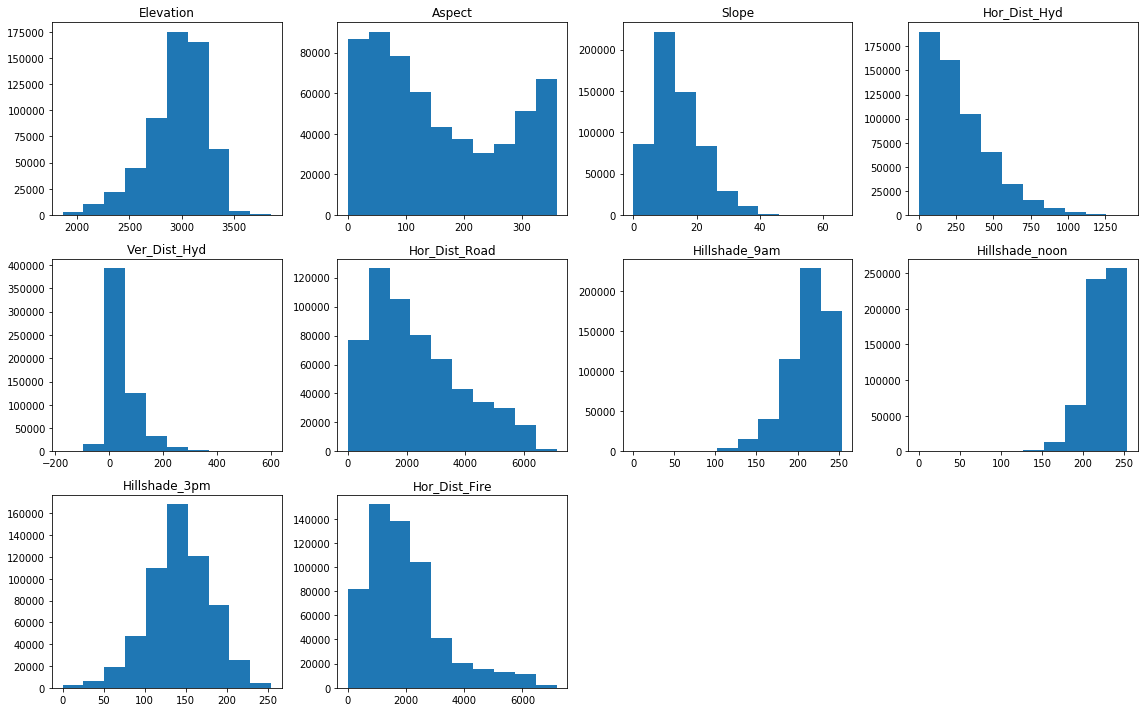

In [11]:
# Visualize distributions of continuous variables
to_hist = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
           'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
           'Hor_Dist_Fire']

plt.figure(figsize=(16,10))
for idx, col in enumerate(to_hist):
    plt.subplot(3, 4, idx+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout();


Some of the continuous variables are skewed right or left, and `Aspect` appears to be bimodal. 

I'm also curious to see whether any of the variables are correlated with one another (and therefore could be eliminated). For instance, there might be a soil type that only occurs in one of the forest preserves. A correlation matrix and heatmap can help us detect this, but it's not a big worry. Principal Components Analysis (below) will help us avoid any repercussions of multicollinearity.

In [12]:
# View correlation matrix
df.corr()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,WA_1,WA_2,WA_3,WA_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,0.131838,0.238164,0.066550,-0.619374,-0.204512,-0.187677,-0.182463,-0.183521,-0.150376,-0.214606,-0.002252,-0.003021,-0.060915,-0.428746,-0.134227,-0.118905,-0.043984,-0.080825,-0.007153,-0.059446,-0.111028,-0.081811,0.033144,-0.043128,0.017557,0.158959,0.124356,0.053582,0.028753,-0.016657,0.035254,-0.029270,0.074327,-0.026667,0.070405,0.167077,0.070633,0.011731,0.083005,0.021107,0.035433,0.217179,0.193595,0.212612,-0.269554
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,-0.140123,0.055988,0.074904,0.082687,-0.007574,-0.005649,-0.002730,0.017212,0.008938,0.010766,-0.005052,-0.003366,-0.020800,0.049835,-0.064344,-0.070209,0.054544,0.007597,-0.002660,0.007846,-0.000168,-0.028353,-0.003635,-0.029440,0.032998,0.021578,0.013676,0.018164,-0.003265,-0.010661,0.011328,0.027535,-0.062181,-0.028922,0.001763,0.056233,0.019163,0.010861,-0.021991,0.002281,-0.020398,0.017706,0.008294,-0.005866,0.017080
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,-0.234576,-0.036253,0.125663,0.255503,0.107847,-0.018553,0.125497,0.131847,0.072311,0.003673,-0.015661,-0.023359,-0.032752,0.244037,-0.050894,-0.169300,0.192423,0.000228,0.001081,-0.034791,-0.040208,-0.045851,-0.083743,-0.077582,-0.025461,-0.053396,-0.207397,0.082434,0.026364,-0.021449,0.043695,0.067052,-0.082941,0.075864,-0.034610,-0.133504,0.208942,-0.011002,-0.022228,0.002918,0.007848,-0.072208,0.093602,0.025637,0.148285
Hor_Dist_Hyd,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,-0.097124,0.055726,0.122028,-0.100433,-0.035096,-0.011569,-0.041211,-0.049071,-0.009370,-0.012916,0.004751,-0.000795,-0.021935,-0.071653,0.001399,0.014628,-0.002032,-0.038478,-0.002667,-0.067448,-0.071435,-0.013340,-0.043236,-0.078088,-0.039953,-0.051424,-0.132244,0.021927,0.016099,0.013408,0.052384,0.026210,-0.001025,-0.049960,0.073658,0.127217,0.101195,0.070268,-0.005231,0.033421,-0.006802,0.043031,0.031922,0.147020,-0.020317
Ver_Dist_Hyd,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,-0.180710,-0.008709,0.146839,0.077792,0.015275,0.008954,0.008863,0.025066,0.026772,0.046259,-0.008485,-0.012915,-0.028476,0.055154,-0.020870,-0.044526,0.083482,-0.024281,-0.001744,-0.050909,-0.054191,-0.031692,-0.055635,-0.076727,-0.026116,-0.075679,-0.180098,0.037066,-0.013471,-0.011212,0.067086,0.071672,-0.075860,-0.011901,0.033609,0.039762,0.167091,0.060274,-0.006092,0.012955,-0.007520,-0.008629,0.043859,0.179006,0.081664
Hor_Dist_Road,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,0.453913,-0.200411,-0.232933,-0.270349,-0.083585,-0.088026,-0.084988,-0.088524,-0.061607,-0.108328,0.020107,0.025805,-0.045813,-0.182955,-0.099293,0.054196,-0.054968,-0.033945,-0.003144,0.018083,-0.051825,-0.051243,0.068758,0.056595,-0.014890,0.046979,-0.007067,-0.032451,-0.034842,0.002521,0.003866,-0.032749,0.306324,0.077091,-0.058840,-0.089019,-0.082779,0.006390,-0.003000,0.007550,0.016313,0.079778,0.033762,0.016052,-0.153450
Hillshade_9am,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,0.201299,-0.006181,-0.100565,-0

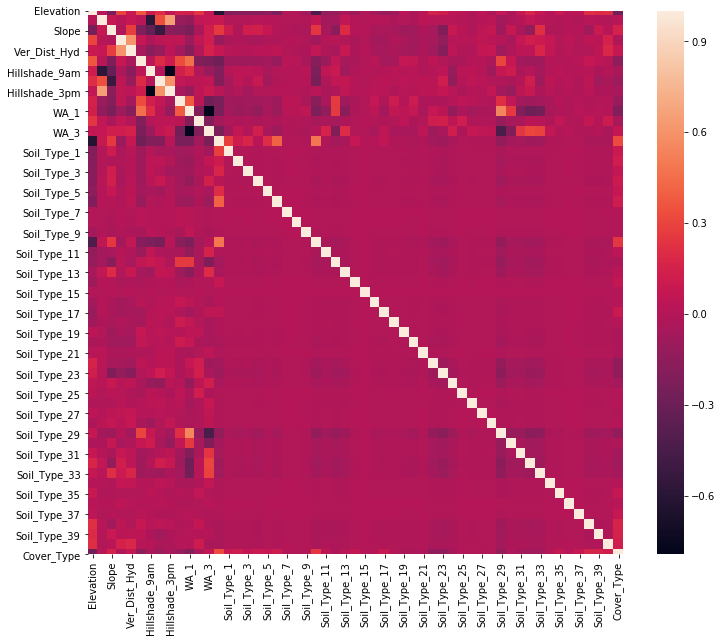

In [13]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr());

It looks like +/-0.6 is about the strongest correlation among any two variables. If it were 0.8, I would be worried about multicollinearity, but I don't think 0.6 poses a real problem. At any rate, the Principal Components Analysis I'll do later will remove any multicollinearity.

I suspect that not all of these features are useful for prediction (especially all those soil types). To test this, I will run a quick Random Forest model and look at the feature importances. If a number of features seem really unimportant for prediction, I can combine/eliminate them using Principal Components Analysis.

In [14]:
# Get a random sample of observations for testing
quick_sample = df.sample(10000, random_state=1)
quick_sample_y = quick_sample['Cover_Type']
quick_sample_x = quick_sample.drop('Cover_Type', axis=1)

# Create and fit a Random Forest classifier to the quick sample data
trial_forest = RandomForestClassifier()
trial_forest.fit(quick_sample_x, quick_sample_y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.9905


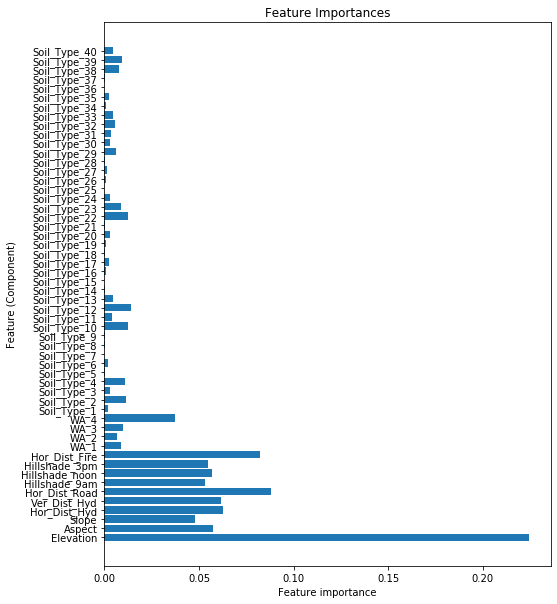

In [15]:
# Visualize the feature importances from the Random Forest trial
print(trial_forest.score(quick_sample_x, quick_sample_y))
n_features = quick_sample_x.shape[1]
plt.figure(figsize=(8,10))
plt.barh(range(n_features), trial_forest.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), quick_sample_x.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature (Component)")
plt.title('Feature Importances');

Judging by this quick-and-dirty analysis, there may be about 14 features (all of them soil types) that have little importance for prediction. Rather than identify and eliminate them manually, I will use Principal Components Analysis (below) to reduce the dimensions of the dataset to 40.

# Preprocessing

In this section I manipulate the data to prepare it for modeling.

## Train-validation-test split

First up is the train-test split. Note that I am actually making two splits. First, I take 80% of the total dataset to use as my training data. Then I take the remaining 20% of the original dataset and devote half of that to validation and half to be used as a true holdout set, which I will only use to evaluate the final versions of each of my models.

Note also that I am doing stratified splits so that each subset will contain all the classes in the same proportions as in the original dataset.

In [0]:
# Split first into training and test datasets
y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [0]:
# Split again into validation and true holdout (test) datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1,
                                                stratify=y_test)

In [18]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(464809, 54) (464809,)
(58101, 54) (58101,)
(58102, 54) (58102,)


I know that later I will want to compare model performance on the raw data and the preprocessed version, so at this point (before preprocessing) I will save copies for later.

In [0]:
# Save raw copies of train and validation sets before further preprocessing
X_train_raw = X_train.copy()
y_train_raw = y_train.copy()

X_val_raw = X_val.copy()
y_val_raw = y_val.copy()

## Resampling

My next preprocessing step is to deal with the class imbalance. My overall strategy is to undersample the bigger classes and oversample the smaller ones so that every class is the same size as the median-sized class.

First, I'll put the training data back into one DataFrame to make things a little easier.

In [20]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
print(len(df_train))
df_train.head()

464809


,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,WA_1,WA_2,WA_3,WA_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
450015,3250,35,4,534,212,2969,219,231,148,3161,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
127010,2580,61,20,30,-1,1061,232,193,85,553,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
247694,2216,41,38,384,251,424,194,129,40,295,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
548749,3166,181,17,242,61,3252,224,248,152,630,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
29431,2900,296,25,210,92,5076,142,223,218,4763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Next, let's review the current counts of all the classes.

In [21]:
# Check for class imbalance
df_train.Cover_Type.value_counts()

2    226640
1    169472
3     28603
7     16408
6     13894
5      7594
4      2198
Name: Cover_Type, dtype: int64

Now I can use `RandomUnderSampler` and `SMOTE` to undersample the larger classes and oversample the smaller ones, aiming for every class to have 16,408 observations.

In [22]:
# Randomly undersample the larger classes
rus = RandomUnderSampler(random_state=3, 
                         sampling_strategy={1:16408, 2:16408, 3:16408,})


X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Check class counts
Counter(y_rus)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 2198, 5: 7594, 6: 13894, 7: 16408})

In [23]:
# Randomly oversample the smaller classes
smote = SMOTE(random_state=3, sampling_strategy={4:16408, 5:16408, 6:16408})

X_resampled, y_resampled = smote.fit_resample(X_rus, y_rus)

# Check class counts
Counter(y_resampled)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 16408, 5: 16408, 6: 16408, 7: 16408})

The final count above shows that the classes are now balanced.

## Scaling

The next transformation I want to do is to standardize the features. This isn't required for Random Forests, but it is helpful for more complex algorithms like Support Vector Machines (plus it doesn't hurt Random Forests, so I may as well do it now).

In [0]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled)

In [25]:
# Check the results
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05
mean,-6.571413e-16,3.558366e-16,3.648730e-15,-5.165772e-15,-3.480439e-15,-8.050364e-16,-4.751117e-15,-1.113727e-15,1.824595e-15,3.501759e-16,-2.212561e-13,-5.704266e-14,-3.966339e-15,-9.197774e-14,-1.228932e-14,7.522264e-14,2.789544e-13,-1.225475e-13,-2.289413e-14,-4.521181e-14,3.392379e-15,1.219268e-14,-2.613020e-14,-9.852809e-14,1.445609e-14,-1.852339e-13,-4.356315e-14,3.871446e-14,4.320266e-15,-4.077800e-15,-1.157320e-13,-1.977586e-14,1.617115e-14,-4.881829e-14,-3.161880e-14,-3.046729e-13,-1.738723e-13,-3.671387e-14,9.678102e-15,-5.062759e-15,2.740445e-14,2.004291e-14,1.651916e-13,-3.096070e-14,-6.857349e-14,-1.426567e-14,9.486490e-14,-1.636574e-14,3.656541e-14,1.241667e-14,-1.591224e-14,-1.677658e-13,-2.197070e-14,-7.975205e-14
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.120858e+00,-1.423987e+00,-1.962208e+00,-1.090620e+00,-3.324786e+00,-1.287201e+00,-6.938578e+00,-7.290815e+00,-2.908838e+00,-1.375326e+00,-5.583105e-01,-1.830819e-01,-8.493593e-01,-6.710119e-01,-1.459946e-01,-2.007865e-01,-2.531647e-01,-2.304902e-01,-9.874061e-02,-2.056642e-01,-8.346094e-03,-1.104113e-02,-2.623530e-02,-3.950921e-01,-1.627006e-01,-1.251072e-01,-1.822421e-01,-8.852049e-02,-5.110807e-03,-7.774208e-02,-1.847516e-01,-5.829545e-02,-5.607330e-02,-8.881971e-02,-2.286190e-02,-1.490141e-01,-2.274579e-01,-1.266773e-01,-1.695284e-02,-5.448869e-02,-3.082071e-02,-2.469475e-02,-3.062747e-01,-2.257804e-01,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
25%,-8.945149e-01,-8.318577e-01,-7.743657e-01,-7.708600e-01,-7.533096e-01,-7.230251e-01,-5.451907e-01,-5.145001e-01,-6.167281e-01,-7.093079e-01,-5.583105e-01,-1.830819e-01,-8.493593e-01,-6.710119e-01,-1.459946e-01,-2.007865e-01,-2.531647e-01,-2.304902e-01,-9.874061e-02,-2.056642e-01,-8.346094e-03,-1.104113e-02,-2.623530e-02,-3.950921e-01,-1.627006e-01,-1.251072e-01,-1.822421e-01,-8.852049e-02,-5.110807e-03,-7.774208e-02,-1.847516e-01,-5.829545e-02,-5.607330e-02,-8.881971e-02,-2.286190e-02,-1.490141e-01,-2.274579e-01,-1.266773e-01,-1.695284e-02,-5.448869e-02,-3.082071e-02,-2.469475e-02,-3.062747e-01,-2.257804e-01,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
50%,1.014521e-02,-2.852769e-01,-1.804444e-01,-2.315627e-01,-3.110812e-01,-3.030859e-01,2.376729e-01,1.455306e-01,7.522952e-02,-2.251362e-01,-5.583105e-01,-1.830819e-01,-8.

The features have now been standardized so that they all have a mean of 0 and a standard deviation of 1.

Let's just get a quick visual confirmation of this change with some histograms.

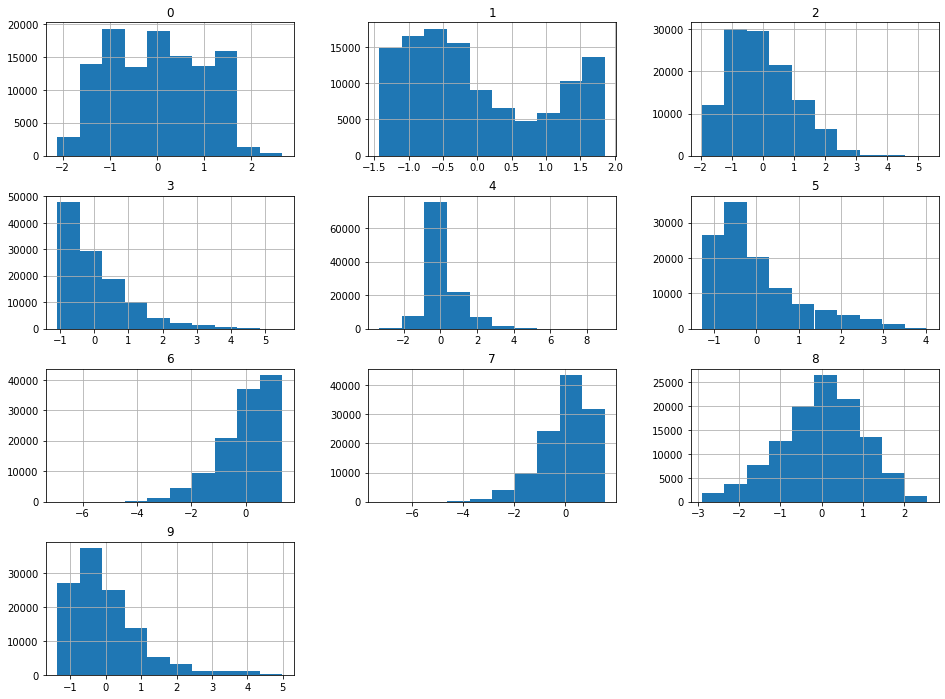

In [26]:
# Visualize the distributions again
X_scaled.loc[:,:9].hist(figsize=(16, 12));

Now that the training data has been scaled, I can move on to PCA.

## PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data. For datasets like the one I'm working with here, where there are lots of features, PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible. For my analysis below, I aim to find a number of components that will explain at least 80% of the variance in the data.

First, let's see how much variance we can explain with a wide range of components. If any of these look promising, we can drill down further.

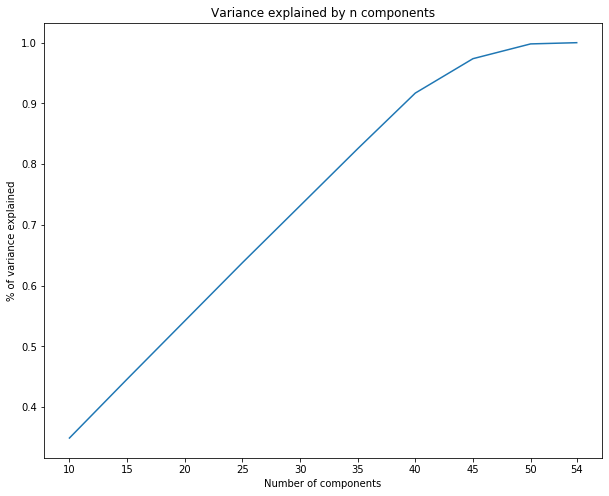

In [27]:
# Try several numbers of components to explain 80% of variance
comps = [10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_scaled)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 54])
plt.show();

Forty components seem to capture about 90% of the variance in the data, which aligns with what we expected based on the feature importances plot above.

In [28]:
# View the % variance explained for each number of components
display(list(zip(comps, var_sums)))

[(10, 0.3489213955726121),
 (15, 0.445865221687779),
 (20, 0.5417182763411437),
 (25, 0.6375852346184023),
 (30, 0.7313794551309782),
 (35, 0.8253044528001957),
 (40, 0.9170275151675227),
 (45, 0.9736568637688149),
 (50, 0.9979901475164933),
 (54, 1.0)]

From the plot and the list above, it's clear that we could explain over 90% of the variance in the data with 40 components (out of a possible 54). Using fewer features/components will help us avoid overfitting on the training data, but at the expense of a little bit of accuracy. I think it's a worthwhile trade.

## Preprocessing pipeline

I know that I want to transform my data so that it is standardized and has 40 components. I will use a pipeline to do this so that I can easily transform my validation and test sets in the same way as my training set without leaking data from one set to another.

In [0]:
# Build a pipeline for the preprocessing steps
pipe_prepro = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=40))])

I will fit the preprocessing pipeline to the training data (which has been resampled), then use the pipeline to transform the validation and test sets separately.

In [0]:
# Fit the pipeline and transform the training dataset
X_train_trans = pipe_prepro.fit_transform(X_resampled)

In [0]:
# Use the pipeline to transform the validation and test datasets
X_val_trans = pipe_prepro.transform(X_val)
X_test_trans = pipe_prepro.transform(X_test)

This transformation will form part of the final pipeline, but by transforming the data now, I can more easily use it to build and evaluate my models.

In [0]:
y_train_res = y_resampled.copy()

# Testing various algorithms

## Random Forest 1

This is a Random Forest with no class balancing, standardization, or PCA.

### Baseline model

In [33]:
# Fit and score a baseline RandomForestClassifier
forest1 = RandomForestClassifier()
forest1.fit(X_train_raw, y_train_raw)

train_pred = forest1.predict(X_train_raw)

print_metrics(y_train_raw, train_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9979518468876464
-------
Confusion matrix:
[[169267    194      0      0      2      1      8]
 [   376 226241      9      0      5      7      2]
 [     0     25  28559      2      1     16      0]
 [     0      0     21   2176      0      1      0]
 [     5    121      3      0   7463      2      0]
 [     2     19     57      2      0  13814      0]
 [    64      7      0      0      0      0  16337]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    169472
           2       1.00      1.00      1.00    226640
           3       1.00      1.00      1.00     28603
           4       1.00      0.99      0.99      2198
           5       1.00      0.98      0.99      7594
           6       1.00      0.99      1.00     13894
           7       1.00      1.00      1.00     16408

    accuracy                           1.00    464809
   macro avg       1.00      0.99      1.00    464809
weighte

In [34]:
# Validate
val_pred = forest1.predict(X_val_raw)

print_metrics(y_val_raw, val_pred)

Accuracy: 0.9411025627786097
-------
Confusion matrix:
[[20001  1127     0     0     7     4    45]
 [ 1104 27058    65     1    40    50    12]
 [    1    86  3400     8     3    77     0]
 [    0     0    47   220     0     8     0]
 [   18   272    17     0   636     7     0]
 [    3    73   196     7     2  1455     0]
 [  132    10     0     0     0     0  1909]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.94      0.94      0.94     21184
           2       0.95      0.96      0.95     28330
           3       0.91      0.95      0.93      3575
           4       0.93      0.80      0.86       275
           5       0.92      0.67      0.78       950
           6       0.91      0.84      0.87      1736
           7       0.97      0.93      0.95      2051

    accuracy                           0.94     58101
   macro avg       0.93      0.87      0.90     58101
weighted avg       0.94      0.94      0.94     58101



### Tune parameters with GridSearchCV

In [35]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [10, 100],
          'max_features': [30, 40, 54],
          'max_depth': [20, 25]}

grid_forest1 = GridSearchCV(forest1, params, cv=3, n_jobs=-1)

grid_forest1.fit(X_train_raw, y_train_raw)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [36]:
# View best score and parameters
grid_forest1_score = grid_forest1.best_score_
grid_forest1_best_params = grid_forest1.best_params_

print('Best score:', grid_forest1_score)
print('Best params:', grid_forest1_best_params)

Best score: 0.9561647902686911
Best params: {'max_depth': 25, 'max_features': 40, 'n_estimators': 100}


In [37]:
# View training metrics for the best model
y_pred = grid_forest1.predict(X_train_raw)
print_metrics(y_train_raw, y_pred)

Accuracy: 0.9933779251262347
-------
Confusion matrix:
[[167579   1888      0      0      5      0      0]
 [   174 226452      0      0      9      5      0]
 [     0    112  28484      0      0      7      0]
 [     0      0      1   2196      0      1      0]
 [     2    680      2      0   6909      1      0]
 [     0     87      1      0      0  13806      0]
 [    96      7      0      0      0      0  16305]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99    169472
           2       0.99      1.00      0.99    226640
           3       1.00      1.00      1.00     28603
           4       1.00      1.00      1.00      2198
           5       1.00      0.91      0.95      7594
           6       1.00      0.99      1.00     13894
           7       1.00      0.99      1.00     16408

    accuracy                           0.99    464809
   macro avg       1.00      0.98      0.99    464809
weighte

In [38]:
# View validation metrics for the best model
y_pred = grid_forest1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

Accuracy: 0.9640109464553106
-------
Confusion matrix:
[[20239   900     0     0     6     2    37]
 [  451 27760    34     0    43    32    10]
 [    0    53  3458     9     3    52     0]
 [    0     0    31   238     0     6     0]
 [    9   202    14     0   720     5     0]
 [    1    38    70     3     2  1622     0]
 [   71     6     0     0     1     0  1973]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.96     21184
           2       0.96      0.98      0.97     28330
           3       0.96      0.97      0.96      3575
           4       0.95      0.87      0.91       275
           5       0.93      0.76      0.83       950
           6       0.94      0.93      0.94      1736
           7       0.98      0.96      0.97      2051

    accuracy                           0.96     58101
   macro avg       0.96      0.92      0.94     58101
weighted avg       0.96      0.96      0.96     58101



## Random Forest 2

This is a Random Forest using the training set that has been resampled, standardized, and transformed with PCA.

### Baseline model

In [39]:
# Fit and score a baseline RandomForestClassifier
forest2 = RandomForestClassifier()
forest2.fit(X_train_trans, y_train_res)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
# Evaluate
y_pred = forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.996395486522254
-------
Confusion matrix:
[[16335    42     1     0     3     2    25]
 [  123 16240    12     0    17    12     4]
 [    0     1 16378     6     1    22     0]
 [    0     0     5 16401     0     2     0]
 [    2    16     3     0 16386     1     0]
 [    1     1    62    26     6 16312     0]
 [   14     4     0     0     0     0 16390]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     16408
           2       1.00      0.99      0.99     16408
           3       0.99      1.00      1.00     16408
           4       1.00      1.00      1.00     16408
           5       1.00      1.00      1.00     16408
           6       1.00      0.99      1.00     16408
           7       1.00      1.00      1.00     16408

    accuracy                           1.00    114856
   macro avg       1.00      1.00      1.00    114856
weighted avg       1.00      1.00      1.00    114856



In [41]:
# Validate 
y_pred = forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8231183628508976
-------
Confusion matrix:
[[18073  2301    15     0   143    40   612]
 [ 4505 21783   510    12   859   552   109]
 [    2    23  3288    41     9   212     0]
 [    0     0    16   248     0    11     0]
 [   13    40    16     0   872     9     0]
 [    2    14   141    14     4  1561     0]
 [   47     4     0     0     1     0  1999]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.80      0.85      0.82     21184
           2       0.90      0.77      0.83     28330
           3       0.82      0.92      0.87      3575
           4       0.79      0.90      0.84       275
           5       0.46      0.92      0.61       950
           6       0.65      0.90      0.76      1736
           7       0.73      0.97      0.84      2051

    accuracy                           0.82     58101
   macro avg       0.74      0.89      0.80     58101
weighted avg       0.84      0.82      0.83     58101



The Random Forest scored over 99% accuracy on the training set and 82% on the validation set! The Random Forest is probably overfit to the training data. Below I'll use a grid search to see if there are other parameters that would help the Random Forest perform better on the validation set.

For now, let's take a look at the importance the Random Forest assigned to each of the 40 components.

In [42]:
# Check the feature importances
forest2.feature_importances_

array([0.08246777, 0.0129423 , 0.02055541, 0.01996136, 0.01798352,
       0.01533155, 0.04323785, 0.02456184, 0.03054897, 0.0221972 ,
       0.02375608, 0.02463589, 0.0265743 , 0.02289252, 0.02833921,
       0.01738256, 0.02032123, 0.03013794, 0.02742376, 0.02452776,
       0.02466996, 0.02485073, 0.02385575, 0.01269406, 0.02786883,
       0.03020926, 0.02360446, 0.02773516, 0.02613266, 0.01750695,
       0.01378035, 0.02584689, 0.01785867, 0.018686  , 0.02428663,
       0.02286449, 0.04776844, 0.01385219, 0.03033672, 0.00981279])

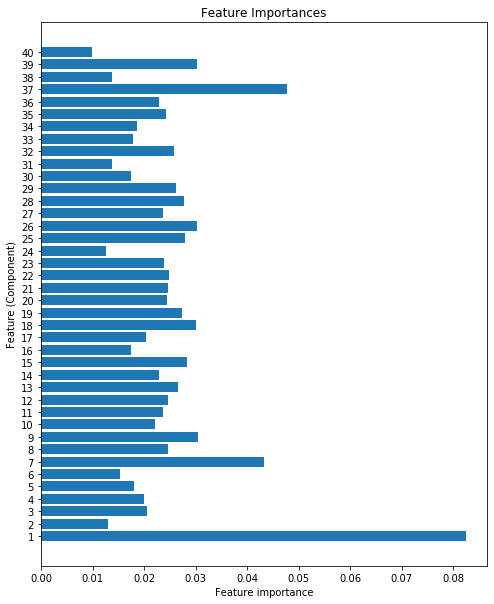

In [44]:
# Visualize feature importances
plot_feature_importances(forest2, X_train_trans)

The plot above shows that there are a few features that are a bit more powerful than the rest. A grid search (below) will help me determine if a different maximum depth of tree or a different number of trees would improve performance.

### Tune parameters with GridSearchCV

In [45]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [100],
          'max_features': [20, 40],
          'max_depth': [20, 25],
          'min_samples_leaf': [5, 10, 20]}

grid_forest2 = GridSearchCV(forest2, params, cv=3, n_jobs=-1)

grid_forest2.fit(X_train_trans, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [46]:
# View best score and parameters
print('Best score:', grid_forest2.best_score_)
print('Best params:', grid_forest2.best_params_)

Best score: 0.8972626593299435
Best params: {'max_depth': 25, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


In [47]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.9730009751340809
-------
Confusion matrix:
[[15566   473     8     0    79    23   259]
 [  404 15314   194     3   266   187    40]
 [    0    19 15878   142    23   346     0]
 [    0     0    28 16368     0    12     0]
 [    6    55    16     0 16305    26     0]
 [    4    25   185   148    29 16017     0]
 [   85    12     0     0     4     0 16307]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     16408
           2       0.96      0.93      0.95     16408
           3       0.97      0.97      0.97     16408
           4       0.98      1.00      0.99     16408
           5       0.98      0.99      0.98     16408
           6       0.96      0.98      0.97     16408
           7       0.98      0.99      0.99     16408

    accuracy                           0.97    114856
   macro avg       0.97      0.97      0.97    114856
weighted avg       0.97      0.97      0.97    114856



In [48]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8297103320080549
-------
Confusion matrix:
[[17746  2440    18     0   205    41   734]
 [ 3432 22487   561    12  1101   615   122]
 [    0    15  3226    58    12   264     0]
 [    0     0    20   248     0     7     0]
 [    6    27    15     0   889    13     0]
 [    0    12   101    19     5  1599     0]
 [   36     2     0     0     1     0  2012]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     21184
           2       0.90      0.79      0.84     28330
           3       0.82      0.90      0.86      3575
           4       0.74      0.90      0.81       275
           5       0.40      0.94      0.56       950
           6       0.63      0.92      0.75      1736
           7       0.70      0.98      0.82      2051

    accuracy                           0.83     58101
   macro avg       0.72      0.90      0.78     58101
weighted avg       0.85      0.83      0.83     58101



## Evaluating the best Random Forest classifier

In [50]:
# Review feature importances for the model with the best parameters
forest_best = RandomForestClassifier(max_depth=25, max_features=20, 
                                     min_samples_leaf=5, n_estimators=100)
forest_best.fit(X_train_trans, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

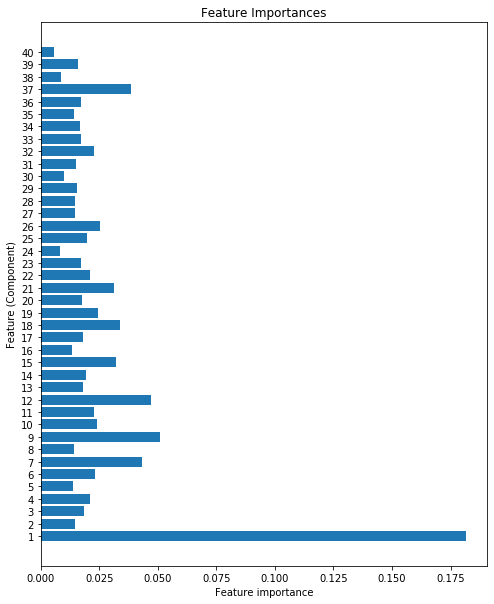

In [51]:
plot_feature_importances(forest_best, X_train_trans)

In [52]:
# View metrics for the optimized model
y_pred = forest_best.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.972644006408024
-------
Confusion matrix:
[[15576   471    10     0    77    24   250]
 [  417 15284   200     2   271   191    43]
 [    0    19 15871   146    22   350     0]
 [    0     0    28 16363     0    17     0]
 [    7    52    16     0 16310    23     0]
 [    3    22   192   155    32 16004     0]
 [   86    12     0     0     4     0 16306]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     16408
           2       0.96      0.93      0.95     16408
           3       0.97      0.97      0.97     16408
           4       0.98      1.00      0.99     16408
           5       0.98      0.99      0.98     16408
           6       0.96      0.98      0.97     16408
           7       0.98      0.99      0.99     16408

    accuracy                           0.97    114856
   macro avg       0.97      0.97      0.97    114856
weighted avg       0.97      0.97      0.97    114856



In [53]:
# View the metrics for the best model
y_pred = forest_best.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8305536909863858
-------
Confusion matrix:
[[17770  2427    22     0   204    41   720]
 [ 3438 22533   544    11  1074   604   126]
 [    0    19  3212    58    16   270     0]
 [    0     0    20   247     0     8     0]
 [    4    32    14     0   887    13     0]
 [    0     8   105    20     7  1596     0]
 [   38     1     0     0     1     0  2011]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     21184
           2       0.90      0.80      0.84     28330
           3       0.82      0.90      0.86      3575
           4       0.74      0.90      0.81       275
           5       0.41      0.93      0.57       950
           6       0.63      0.92      0.75      1736
           7       0.70      0.98      0.82      2051

    accuracy                           0.83     58101
   macro avg       0.72      0.89      0.78     58101
weighted avg       0.85      0.83      0.83     58101



In [68]:
# Evalutate performance on test data
y_pred_test_forest = forest_best.predict(X_test_trans)
print_metrics(y_test, y_pred_test_forest)

Accuracy: 0.8279577295101718
-------
Confusion matrix:
[[17677  2525    19     0   189    40   734]
 [ 3530 22454   570     6  1034   606   131]
 [    0    15  3220    72    11   258     0]
 [    0     0    20   249     0     5     0]
 [    5    29    12     0   900     3     0]
 [    0    12   101    19     6  1599     0]
 [   40     4     0     0     0     0  2007]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83     21184
           2       0.90      0.79      0.84     28331
           3       0.82      0.90      0.86      3576
           4       0.72      0.91      0.80       274
           5       0.42      0.95      0.58       949
           6       0.64      0.92      0.75      1737
           7       0.70      0.98      0.82      2051

    accuracy                           0.83     58102
   macro avg       0.72      0.90      0.78     58102
weighted avg       0.84      0.83      0.83     58102



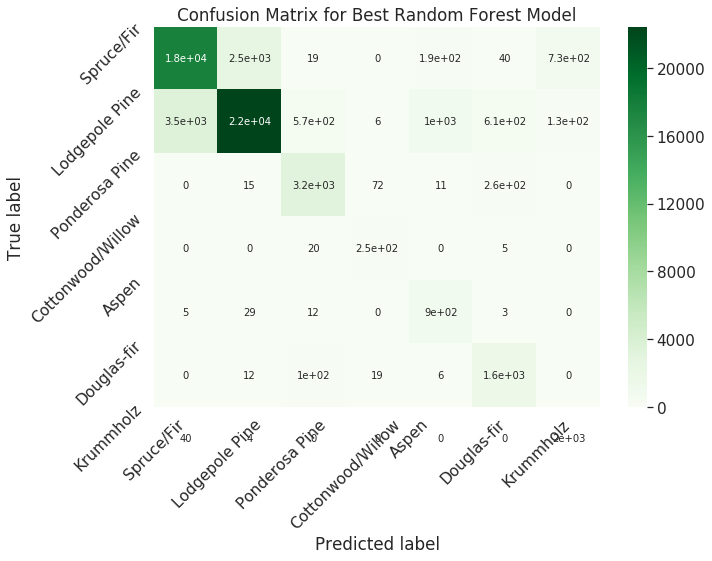

In [174]:
# Display color-coded confusion matrix
pretty_confusion(y_test, y_pred_test_forest, 'Best Random Forest Model')

In [0]:
# Pickle the model
with open('forest.pickle', 'wb') as f:
    pickle.dump(forest_best, f, pickle.HIGHEST_PROTOCOL)

## XGBoost

intro

### Baseline model

In [0]:
xg = xgb.XGBClassifier()

In [70]:
xg.fit(X_train_trans, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [71]:
y_pred = xg.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

Accuracy: 0.728294560144877
-------
Confusion matrix:
[[10107  3385     8     0  1033   156  1719]
 [ 3980  8562   371    30  2561   769   135]
 [    0    55 11149  1583   436  3185     0]
 [    0     0   536 15393     2   477     0]
 [  825  1497   550     0 13014   522     0]
 [   69   215  3696  1045   940 10443     0]
 [ 1095   193    12     0   127     0 14981]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.62      0.62     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.85      0.94      0.89     16408
           5       0.72      0.79      0.75     16408
           6       0.67      0.64      0.65     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.72      0.73      0.72    114856
weighted avg       0.72      0.73      0.72    114856



In [72]:
y_pred = xg.predict(X_val_trans)

print_metrics(y_val, y_pred)

Accuracy: 0.579611366413659
-------
Confusion matrix:
[[13029  4347    14     0  1294   199  2301]
 [ 7198 14309   636    57  4470  1394   266]
 [    0    17  2406   340   113   699     0]
 [    0     0    24   240     0    11     0]
 [   54   100    43     0   714    39     0]
 [    5    28   402   106    89  1106     0]
 [  140    23     2     0    14     0  1872]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.76      0.51      0.61     28330
           3       0.68      0.67      0.68      3575
           4       0.32      0.87      0.47       275
           5       0.11      0.75      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.58      2051

    accuracy                           0.58     58101
   macro avg       0.46      0.71      0.51     58101
weighted avg       0.67      0.58      0.60     58101



### Tune parameters with GridSearchCV

In [147]:
params = {'learning_rate': [0.01, 0.1],
          'gamma': [0.1, 1],
          'n_estimators': [5, 30, 100],
          'predictor': ['gpu_predictor'],
          'subsample': [0.7]
}

grid_xgb = GridSearchCV(xg, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_xgb.fit(X_train_trans, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [0.1, 1], 'learning_rate': [0.01, 0.1],
                         'n_estimators': [5, 30, 100],
                         'predictor': ['g

In [148]:
print('Best score:', grid_xgb.best_score_)
print('Best params:', grid_xgb.best_params_)

Best score: 0.7253778644563628
Best params: {'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'predictor': 'gpu_predictor', 'subsample': 0.7}


In [149]:
y_pred = grid_xgb.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

Accuracy: 0.7306627429128648
-------
Confusion matrix:
[[10305  3207     8     0   978   156  1754]
 [ 4011  8525   363    29  2550   785   145]
 [    0    50 11165  1558   449  3186     0]
 [    0     0   508 15442     2   456     0]
 [  783  1540   552     0 13047   486     0]
 [   51   257  3708  1027   887 10478     0]
 [ 1103   208    13     0   125     0 14959]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.63      0.63     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.86      0.94      0.90     16408
           5       0.72      0.80      0.76     16408
           6       0.67      0.64      0.66     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.73      0.73      0.73    114856
weighted avg       0.73      0.73      0.73    114856



In [150]:
y_pred = grid_xgb.predict(X_val_trans)

print_metrics(y_val, y_pred)

Accuracy: 0.5828643224729351
-------
Confusion matrix:
[[13236  4142    13     0  1242   206  2345]
 [ 7302 14268   630    51  4392  1397   290]
 [    0    16  2416   321   121   701     0]
 [    0     0    24   242     0     9     0]
 [   52    97    44     0   723    34     0]
 [    6    28   405   110    77  1110     0]
 [  139    26     2     0    14     0  1870]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.77      0.50      0.61     28330
           3       0.68      0.68      0.68      3575
           4       0.33      0.88      0.48       275
           5       0.11      0.76      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.57      2051

    accuracy                           0.58     58101
   macro avg       0.47      0.71      0.51     58101
weighted avg       0.68      0.58      0.61     58101



## Evaluating the best XGBoost classifier

In [152]:
# Build the optimized model
xgb_best = xgb.XGBClassifier(gamma=1, learning_rate=0.1, n_estimators=100, 
                             predictor='gpu_predictor', subsample=0.7) 
xgb_best.fit(X_train_trans, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, verbosity=1)

In [153]:
# View metrics for the optimized model
y_pred = xgb_best.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.7306627429128648
-------
Confusion matrix:
[[10305  3207     8     0   978   156  1754]
 [ 4011  8525   363    29  2550   785   145]
 [    0    50 11165  1558   449  3186     0]
 [    0     0   508 15442     2   456     0]
 [  783  1540   552     0 13047   486     0]
 [   51   257  3708  1027   887 10478     0]
 [ 1103   208    13     0   125     0 14959]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.63      0.63     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.86      0.94      0.90     16408
           5       0.72      0.80      0.76     16408
           6       0.67      0.64      0.66     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.73      0.73      0.73    114856
weighted avg       0.73      0.73      0.73    114856



In [154]:
# View full metrics for the validation set
y_val_pred = xgb_best.predict(X_val_trans)
print_metrics(y_val, y_val_pred)

Accuracy: 0.5828643224729351
-------
Confusion matrix:
[[13236  4142    13     0  1242   206  2345]
 [ 7302 14268   630    51  4392  1397   290]
 [    0    16  2416   321   121   701     0]
 [    0     0    24   242     0     9     0]
 [   52    97    44     0   723    34     0]
 [    6    28   405   110    77  1110     0]
 [  139    26     2     0    14     0  1870]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.77      0.50      0.61     28330
           3       0.68      0.68      0.68      3575
           4       0.33      0.88      0.48       275
           5       0.11      0.76      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.57      2051

    accuracy                           0.58     58101
   macro avg       0.47      0.71      0.51     58101
weighted avg       0.68      0.58      0.61     58101



In [155]:
# View full metrics for the validation set
y_pred_test_xgb = xgb_best.predict(X_test_trans)
print_metrics(y_test, y_pred_test_xgb)

Accuracy: 0.581150390692231
-------
Confusion matrix:
[[13167  4233    15     0  1304   185  2280]
 [ 7281 14183   662    45  4472  1397   291]
 [    0     7  2442   355    99   673     0]
 [    0     0    17   244     0    13     0]
 [   36    98    50     0   732    33     0]
 [    5    36   397    93    82  1124     0]
 [  151    18     0     0     8     0  1874]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.76      0.50      0.60     28331
           3       0.68      0.68      0.68      3576
           4       0.33      0.89      0.48       274
           5       0.11      0.77      0.19       949
           6       0.33      0.65      0.44      1737
           7       0.42      0.91      0.58      2051

    accuracy                           0.58     58102
   macro avg       0.47      0.72      0.51     58102
weighted avg       0.67      0.58      0.61     58102



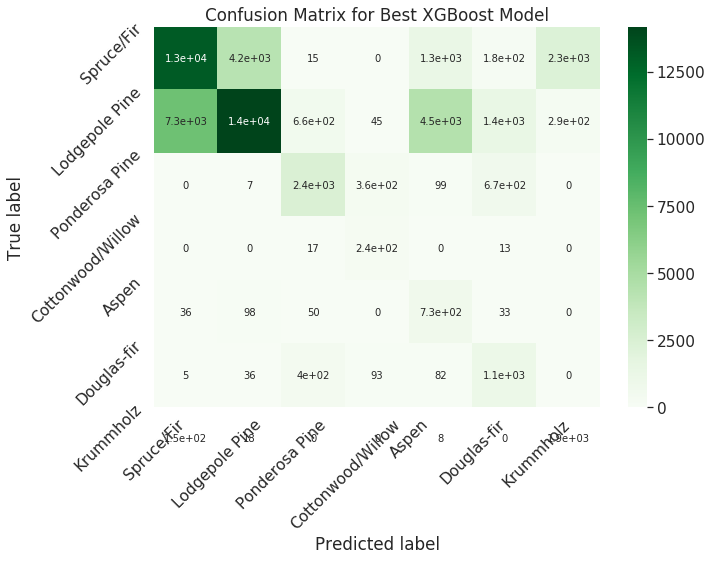

In [175]:
# Display color-coded confusion matrix
pretty_confusion(y_test, y_pred_test_xgb, 'Best XGBoost Model')

In [0]:
# Pickle the model
with open('xgb.pickle', 'wb') as f:
    pickle.dump(xgb_best, f, pickle.HIGHEST_PROTOCOL)

## Support Vector Machine

### Baseline model

In [177]:
# Build a baseline model
svc = SVC(gamma='auto')
svc.fit(X_train_trans, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [178]:
y_pred = svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.7576182350073135
-------
Confusion matrix:
[[11489  2856    10     0   555   101  1397]
 [ 3495  9629   370    19  2165   587   143]
 [    0   101 10921  1610   424  3352     0]
 [    0     0   549 15437     0   422     0]
 [  238  1461   480     0 13781   448     0]
 [   19   531  3235  1099   331 11193     0]
 [ 1791    41     4     0     5     0 14567]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.67      0.70      0.69     16408
           2       0.66      0.59      0.62     16408
           3       0.70      0.67      0.68     16408
           4       0.85      0.94      0.89     16408
           5       0.80      0.84      0.82     16408
           6       0.70      0.68      0.69     16408
           7       0.90      0.89      0.90     16408

    accuracy                           0.76    114856
   macro avg       0.75      0.76      0.76    114856
weighted avg       0.75      0.76      0.76    114856



In [179]:
y_pred = svc.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.6490077623448822
-------
Confusion matrix:
[[14923  3623    13     0   713   100  1812]
 [ 6235 16323   655    28  3804  1015   270]
 [    0    38  2402   326    94   715     0]
 [    0     0    13   253     0     9     0]
 [   12    95    35     0   766    42     0]
 [    4    51   350   103    21  1207     0]
 [  214     2     0     0     1     0  1834]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.70      0.70      0.70     21184
           2       0.81      0.58      0.67     28330
           3       0.69      0.67      0.68      3575
           4       0.36      0.92      0.51       275
           5       0.14      0.81      0.24       950
           6       0.39      0.70      0.50      1736
           7       0.47      0.89      0.61      2051

    accuracy                           0.65     58101
   macro avg       0.51      0.75      0.56     58101
weighted avg       0.72      0.65      0.67     58101



### Tune parameters with GridSearchCV

In [1]:
params = {'gamma': [0.1, 1.0, 100.0],
          'C': [0.1, 1.0, 10.0]}

grid_svc = GridSearchCV(svc, params, cv=3, scoring='accuracy')
grid_svc.fit(X_train_trans, y_train_res)

NameError: ignored

In [0]:
print('Best score:', grid_svc.best_score_)
print('Best params:', grid_svc.best_params_)

KeyboardInterrupt: 

In [0]:
y_pred = grid_svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

In [0]:
y_pred = grid_svc.predict(X_val_trans)
print_metrics(y_val, y_pred)

### Evaluating the best Support Vector classifier

In [0]:
# Build the optimized model
# svc_best = SVC() # insert best params
# svc_best.fit(X_train_trans, y_train_res)

In [0]:
# View metrics for the optimized model
# y_pred = svc_best.predict(X_train_trans)
# print_metrics(y_train_res, y_pred)

In [0]:
# Score the model on the validation set
# svc_best.score(X_val_trans, y_val)

In [0]:
# View full metrics for the validation set
# y_val_pred = svc_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [0]:
# Find AUC and plot ROC curve
# y_score_svc = svc_best.fit(X_train_trans, y_train_res).decision_function(X_test_trans)

# roc_it(y_test, y_score_xg)

In [0]:
# Pickle the model
# with open('svc.pickle', 'wb') as f:
#   pickle.dump(svc_best, f, pickle.HIGHEST_PROTOCOL)

# Pipeline

In [0]:
pipe = Pipeline([('scaler', StandardScaler),
                 ('pca', PCA(n_components=40)),
                ])



# Interpretations and recommendations

## Interpretation

## Recommendations

## Future work

## Non-technical visualizations

In [0]:
# Get tree type counts
tree_dict = {1:'Spruce/Fir', 
             2:'Lodgepole Pine', 
             3:'Ponderosa Pine',
             4:'Cottonwood/Willow', 
             5:'Aspen', 
             6:'Douglas-fir', 
             7:'Krummholz'}

tree_list = list(tree_dict.values())

class_counts = [df.Cover_Type.value_counts()[i] for i in range(1,8)]

tree_counts = sorted(list(zip(tree_list, class_counts)), 
                     key=lambda x:x[1], reverse=True)

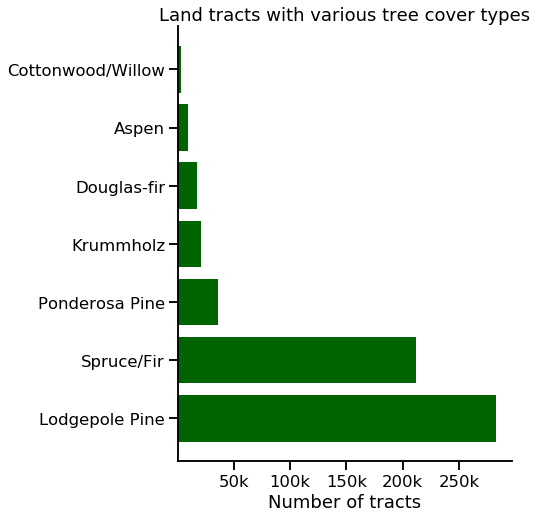

In [0]:
# Plot tree type counts
plt.figure(figsize=(6,8))
plt.barh(width=[x[1] for x in tree_counts], 
         y=[x[0] for x in tree_counts], 
         color='darkgreen')
plt.yticks(ticks=list(range(0,7)), labels=[x[0] for x in tree_counts])
plt.xticks(ticks=[5e4, 10e4, 15e4, 20e4, 25e4], 
           labels=['50k', '100k', '150k', '200k', '250k'])
plt.xlabel('Number of tracts')
plt.title('Land tracts with various tree cover types')
sns.despine()
plt.show();

In [0]:
# Get wilderness area counts
df.loc[:, 'WA_1':'WA_4'].sum()

area_names = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']
wa_counts = [df.loc[:, 'WA_1':'WA_4'].sum()[i] for i in range(4)]
area_counts = sorted(list(zip(area_names, wa_counts)),
                     key=lambda x:x[1], reverse=True)
area_counts

[('Rawah', 260796),
 ('Comanche Peak', 253364),
 ('Cache la Poudre', 36968),
 ('Neota', 29884)]

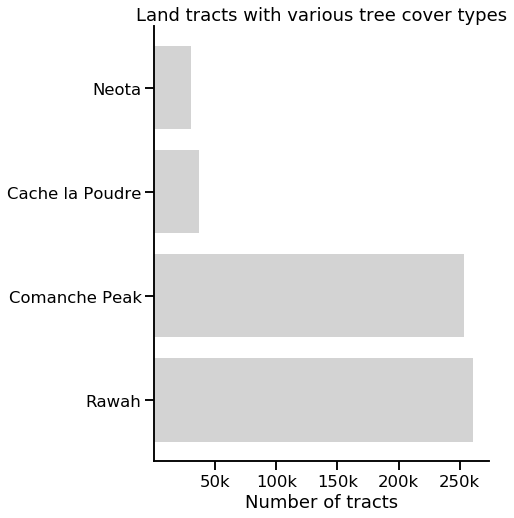

In [0]:
plt.figure(figsize=(6,8))
plt.barh(y=[x[0] for x in area_counts], width=[x[1] for x in area_counts],
        color='lightgray')
plt.xticks(ticks=[5e4, 10e4, 15e4, 20e4, 25e4], 
           labels=['50k', '100k', '150k', '200k', '250k'])
plt.xlabel('Number of tracts')
plt.title('Land tracts with various tree cover types')
sns.despine()
plt.show();

# To cut

### Save copy of the training set

In [0]:
# Save the clean dataset for easier access later
y_train = pd.DataFrame(y_smote, columns=['Cover_Type'])
X_train = pd.DataFrame(X_train_pca)
sample_to_save = pd.concat([X_train, y_train], axis=1)
sample_to_save.to_csv('trees_train.csv')

In [0]:
raw_to_save = pd.concat([X_train_raw, y_train_raw], axis=1)
raw_to_save.to_csv('trees_train_raw.csv')

### Save a copy of the validation set

In [0]:
y_val = pd.DataFrame(y_val, columns=['Cover_Type'])
y_val.reset_index(inplace=True)
y_val.drop('index', axis=1, inplace=True)

In [0]:
X_val = pd.DataFrame(X_val_pca)

In [0]:
val_to_save = pd.concat([X_val, y_val], axis=1, ignore_index=True)
len(val_to_save)

58101

In [0]:
val_to_save.to_csv('trees_val.csv')

In [0]:
val_raw_to_save = pd.concat([X_val_raw, y_val_raw], axis=1)
val_raw_to_save.to_csv('trees_val_raw.csv')

### Reconstitute training and validation sets

In [0]:
train_trans = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_train.csv')
train_trans.drop('Unnamed: 0', axis=1, inplace=True)
train_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,Cover_Type
0,-1.919642,1.545429,-2.154026,0.465190,-0.039087,-0.898641,-0.726181,-0.518156,-0.795170,1.832770,-0.138805,0.128179,0.312822,0.642169,-0.338050,0.345284,-0.143583,-0.230057,0.398625,0.214304,-0.206256,0.246812,0.127521,0.001343,0.139274,-0.053826,-0.072864,0.038964,0.130061,-0.094863,-0.073763,-0.016226,-0.025170,0.043097,-0.013932,-0.002199,-0.036792,0.000732,0.005547,0.380143,1
1,-0.729440,2.842710,-0.805643,0.700709,-0.368983,-0.577724,-0.114275,-0.166068,-0.601834,1.773628,-0.094106,0.195288,0.346119,0.715567,-0.401542,0.401931,-0.058230,-0.296643,0.449127,0.308890,-0.197934,0.328951,0.198096,0.073676,0.192417,-0.052386,-0.060271,0.037031,0.156051,-0.132952,-0.051246,-0.017335,-0.008949,0.047760,0.002531,-0.007379,-0.044616,-0.000500,0.006419,0.723786,1
2,-1.414295,0.465655,-0.421006,-1.710639,-0.866943,1.473237,-0.564235,-0.119146,-0.177979,0.144611,-0.351753,-1.359997,-2.321331,-1.576757,-0.653744,0.731353,0.039865,-1.274285,-0.129857,-0.005465,0.443443,-0.142586,0.285028,0.579230,-0.012948,-0.130535,0.106990,-0.034389,-0.203800,-0.162897,-0.034065,-0.040310,-0.122626,-0.078465,-0.025126,-0.004162,-0.032245,0.003648,0.005026,0.723705,1
3,-1.719740,0.537204,-1.976603,2.532597,-0.914213,-0.833309,-0.546785,-0.474177,0.074945,1.508607,-0.116700,0.031932,0.328077,0.738780,-0.271144,0.298669,-0.077510,-0.320026,0.450990,0.371441,-0.073971,0.401843,0.156568,-0.052216,0.093633,0.000771,-0.051709,0.070042,0.123255,-0.108564,-0.093112,0.012405,-0.039666,0.069022,-0.000290,-0.012513,-0.033794,-0.004891,0.000309,-0.194112,1
4,-1.661729,-0.161570,0.811565,-2.110810,-0.110697,-0.049399,0.393778,1.151023,-0.598367,0.079608,0.876281,-0.290931,-2.049247,3.027078,0.037458,-1.519455,0.907814,-0.314155,0.416904,-0.099493,-0.086155,-0.068519,-0.265700,0.240311,0.029959,-0.126690,-0.378482,-0.051779,-0.116483,0.001089,-0.078067,0.048836,-0.085332,-0.066123,-0.053483,-0.013638,0.028344,-0.002567,-0.006874,0.288379,1


In [0]:
train_raw = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_train_raw.csv')
train_raw.drop('Unnamed: 0', axis=1, inplace=True)
train_raw.head()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,WA_1,WA_2,WA_3,WA_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,3250,35,4,534,212,2969,219,231,148,3161,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2580,61,20,30,-1,1061,232,193,85,553,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2216,41,38,384,251,424,194,129,40,295,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,3166,181,17,242,61,3252,224,248,152,630,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
4,2900,296,25,210,92,5076,142,223,218,4763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
val_trans = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_val.csv')
val_trans.drop('Unnamed: 0', axis=1, inplace=True)
val_trans.rename(columns={'40':'Cover_Type'}, inplace=True)

In [0]:
val_raw = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_val_raw.csv')
val_raw.drop('Unnamed: 0', axis=1, inplace=True)

In [0]:
y_train = train_trans['Cover_Type']
X_train = train_trans.drop('Cover_Type', axis=1)

y_train_raw = train_raw['Cover_Type']
X_train_raw = train_raw.drop('Cover_Type', axis=1)

y_val = val_trans['Cover_Type']
X_val = val_trans.drop('Cover_Type', axis=1)

y_val_raw = val_raw['Cover_Type']
X_val_raw = val_raw.drop('Cover_Type', axis=1)

print('Transformed train & val datasets')
print('Train shape:', X_train.shape, y_train.shape)
print('Val shape:', X_val.shape, y_val.shape)
print('\n')
print('Raw train and val datasets')
print('Train shape:', X_train_raw.shape, y_train_raw.shape)
print('Val shape:', X_val_raw.shape, y_val_raw.shape)

Transformed train & val datasets
Train shape: (114856, 40) (114856,)
Val shape: (58101, 40) (58101,)


Raw train and val datasets
Train shape: (464809, 54) (464809,)
Val shape: (58101, 54) (58101,)
